In [1]:
import sys
#sys.path.insert(1,'/Users/kailaiwang/Documents/AEI_Research/TEOBResumS/eccentric/python')
sys.path.insert(1,'/work/kailai.wang/teobresums/Python')
import EOBRun_module
import SEOBNRE
import sxs
import Functions as fun
from importlib import reload
fun=reload(fun)
import argparse
from configparser import ConfigParser
import corner
import os
import pandas as pd
import glob
import json
import numpy as np
from pycbc import psd
import h5py
from scipy.interpolate import interp1d
from scipy.fft import fft, ifft
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import dynesty
from dynesty import plotting as dyplot
from pycbc.waveform import td_approximants
import pycbc.psd
from pycbc.pool import choose_pool
import csv
##########################
import aux_fun as functions
import SXS_module as sxs
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize,curve_fit
import romspline
import h5py
import math
from dynesty.utils import resample_equal
import corner
import json
import random


In [2]:
try:
    parser = argparse.ArgumentParser(description="Simple argument parser")
    parser.add_argument("-c", action="store", dest="config_file")
    result = parser.parse_args()
    config_file=result.config_file
    parser = ConfigParser()
    parser.read(config_file)
    parser.sections()
except SystemExit: 
    print("SystemExit")
    parser = ConfigParser()
    parser.read('config_TSEOBNRE.ini')
    parser.sections()
    pass

export_folder='/work/kailai.wang/Eccentricity_project/export_folder/rit_mismatch_tseob_new_debug'
export_bool=eval(parser.get('setup','export'))




SystemExit


usage: ipykernel_launcher.py [-h] [-c CONFIG_FILE]
ipykernel_launcher.py: error: unrecognized arguments: -f /work/kailai.wang/.local/share/jupyter/runtime/kernel-9387bb5d-46b0-4dc9-8f85-290f62b45f21.json


In [3]:
import glob
json_files=glob.glob('/work/francisco.jimenez/RIT/Metadata/*Metadata.json',recursive = True)

In [4]:
import importlib
importlib.reload(sxs)
conditions=np.asarray([['BHBH',None],['Non-Precessing',None],['Eccentricity',['>=0.01','<=0.50']]])
ritcat=sxs.SXS_catalogue("/work/francisco.jimenez/RIT/Data",conditions,catalogue="RIT")

systems=np.array([ritcat.metadata(j,parameters_list=['catalog-tag','system-type','eccentricity','relaxed-mass-ratio-1-over-2',
                                                     'final-mass','final-chi','initial-bh-chi1z','initial-bh-chi2z','freq-start-22']) for j in json_files])

/work/kailai.wang/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


In [5]:
boolean= np.array(['e' in elist for elist in systems[:,0]])

for i in range(len(systems)):
    if 'e' in systems[:,0][i] and float(systems[:,2][i])<0.5:
        boolean[i]=True
    else:
        boolean[i]=False

ecc_prec_cases=systems[boolean]
boolean = np.array(['Precessing' not in elist for elist in ecc_prec_cases])
ecc_cases=ecc_prec_cases[boolean]
ecc_cases[:,2]=np.array([float(i[2]) for i in ecc_cases])
ecc_cases[:,3]=np.array([1/float(i[3]) for i in ecc_cases])
ecc_cases[:,4]=np.array([float(i[4]) for i in ecc_cases])
ecc_cases[:,5]=np.array([float(i[5]) for i in ecc_cases])
ecc_tags=ecc_cases[:,0]


h5_files=[glob.glob('/work/francisco.jimenez/RIT/Data/*'+j.replace(':','-')+'*',recursive = True)[0] for j in ecc_tags]

In [6]:
modes=[[2,2]]
len(ecc_tags),len(h5_files)

(252, 252)

In [7]:

# for i in ecc_cases:
#     if i[0]==tag:
#         print(i)

In [8]:
# tag

[]
Found! RIT:eBBH:1540
system type: Nonspinning
eccentricity 0.4671
relaxed_mass_ratio_1_over_2: 3
final_mass: 0.984896585
final_chi: 0.3809913511
initial_bh_chi1z: 0
initial_bh_chi2z: 0
initial_freq: 0.002463369913


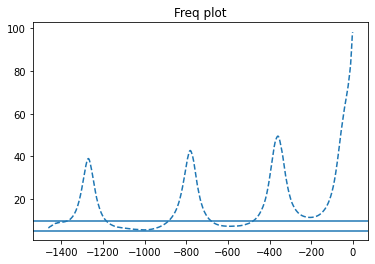

massratio:  3
mass1:  75.0
mass2:  25.0
spin1:  0.0
spin2:  0.0
Meta eccentricity 0.4671
eccentricity:  nan
initial physical frequency:  5.0023227149269545
---------------
Running dynesty...


/work/kailai.wang/venv/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in double_scalars
1554it [11:10,  2.32it/s, bound: 0 | nc: 2 | ncall: 4717 | eff(%): 32.945 | loglstar:   -inf < -1.098 <    inf | logz: -1.393 +/-  0.015 | dlogz:  0.267 >  0.100] 


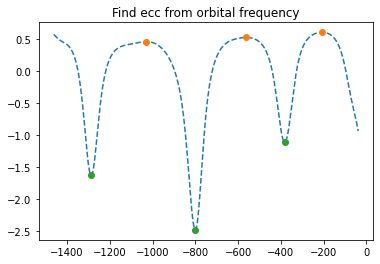

In [9]:
wave={}
h5_files_list=[]
# x=0
# while x<252:
#     h5_files_list.append(x)
#     x+=90
    
    
print(h5_files_list)

for i in range(18, 19):
    try:
        tag=ecc_tags[i]
        wave[tag]=sxs.Generate_Georgia_Waveform(h5_files[i],modes,
                                        zero_align=False,
                                        sampling_rate=0.1,modes_combined=False,inclination=0,
                                        coa_phase=0,RD=False,toffset=0)
        rit_t=wave[ecc_tags[i]][0][:,0]
        rit_h=wave[ecc_tags[i]][0][:,1]
        #----------------------------------------------------------------------
        for name in ecc_cases:
            if name[0]==ecc_tags[i]:
                ritwavename=str(name[0])
                print("Found! " + str(name[0]))
                system_type=name[1]
                print("system type: " + str(system_type))
                eccentricity = name[2]
                print("eccentricity "+str(eccentricity))
                relaxed_mass_ratio_1_over_2=name[3]
                print("relaxed_mass_ratio_1_over_2: "+ str(relaxed_mass_ratio_1_over_2))
                final_mass=name[4]
                print("final_mass: "+ str(final_mass))
                final_chi=name[5]
                print("final_chi: "+ str(final_chi))
                initial_bh_chi1z=name[6]
                print("initial_bh_chi1z: "+ str(initial_bh_chi1z))
                initial_bh_chi2z=name[7]
                print("initial_bh_chi2z: "+ str(initial_bh_chi2z))
                initial_freq=float(name[8])
                print(("initial_freq: "+ str(initial_freq)))
        #----------------------------------------------------------------------
        rit_wave_int=interp1d(rit_t.real,rit_h, kind='cubic')
        mass=100
        sxs_wave_int=rit_wave_int
        times=rit_t.real
        #print(times[0])
        dt=fun.time_to_t_NR(1/1024.,mass)
        times= np.arange(times[0], times[-1], dt)
        sxs_wave = sxs_wave_int(times)
        if times[0]+200>=-1500:
            boolean=np.logical_and(times >= (times[0]+50), times<=0)
        else:
            boolean=np.logical_and(times >= (times[0]+50), times<=0)

        sxs_wave = sxs_wave[boolean]
        times = times[boolean]
    #----------------------------------------------------------------------
        sxsphas = np.angle(sxs_wave)
        sxsphas = np.unwrap(sxsphas)
        sxsfreq = np.gradient(sxsphas, times)
        sxsfreq_int = interp1d(times,sxsfreq,kind='cubic')
        plt.plot(times, fun.f_to_Phys(sxsfreq,mass)/(2*np.pi), '--', label=r'$\Re{(Rh_{22}/(M\nu))}$')
        plt.axhline(fun.f_to_Phys(initial_freq,mass))
        plt.axhline(fun.f_to_Phys(2*initial_freq,mass))
        plt.title("Freq plot")
        plt.show()
    #----------------------------------------------------------------------
        ecc_nr=eccentricity
        massratio=relaxed_mass_ratio_1_over_2
        mass1=100*1/(massratio+1)*massratio
        mass2=100*1/(massratio+1)
        spin1=float(initial_bh_chi1z)
        spin2=float(initial_bh_chi2z)
        omega_0=initial_freq*2*np.pi
        T_0= 2*np.pi/omega_0
        f_0 = omega_0/(2*np.pi)
        bool_fact=times<=times[0]+300+8*T_0
        times_fit=times[bool_fact]
        sxsfreq_fit=sxsfreq[bool_fact]
        freqcfit=np.polyfit(times_fit, sxsfreq_fit, 2)
        sxsfreq_fitc = np.poly1d(freqcfit)
        sxsfreq_ecc_estimate=1-sxsfreq_fit/sxsfreq_fitc(times_fit)
        sxsfreq_ecc_estimate=fun.moving_average(sxsfreq_ecc_estimate, 20)
        times_fit = times_fit[:-19]
        peaks_pos=find_peaks(sxsfreq_ecc_estimate, height=0)
        peaks_neg=find_peaks(-sxsfreq_ecc_estimate, height=-0)
        plt.plot(times_fit, sxsfreq_ecc_estimate, '--', label=r'$circular$')
        plt.plot(times_fit[peaks_pos[0]], peaks_pos[1]['peak_heights'], 'o', label=r'$circular$')
        plt.plot(times_fit[peaks_neg[0]],-peaks_neg[1]['peak_heights'], 'o', label=r'$circular$')
        plt.title("Find ecc from orbital frequency")
        # eccentricity estimate as in Eq. 2.8 odf 1909.11011
        wp =omega_0*(1 + np.mean(peaks_pos[1]['peak_heights']))
        wa =omega_0*(1 - np.mean(peaks_neg[1]['peak_heights']))
        ecc_NR = (wp**0.5 - wa**0.5)/(wp**0.5 + wa**0.5)
        initial_freq_phys=fun.f_to_Phys(initial_freq,mass)
        print('massratio: ',massratio)
        print('mass1: ',mass1)
        print('mass2: ',mass2)
        print('spin1: ',spin1)
        print('spin2: ',spin2)
        print('Meta eccentricity', eccentricity)
        print('eccentricity: ', ecc_NR)
        print('initial physical frequency: ', fun.f_to_Phys(initial_freq,mass))
        print('---------------')

    #----------------------------------------------------------------------
        emin=0
        distance = 100; inclination = 0; l=2; m=2;
        emax=0.5
        #for i=1, bvals=np.array([ 0.37419166, 14.98812769])
        #for i=589, bvals=bvals=np.array([0.03056081, 24.91583345])
        #bvals=np.array([0.03056081, 24.91583345])
        bvals=[]
        model='TSEOBNRE'
        #model='SEOBNRE'
        # list=[mass1,mass2,spin1,spin2,distance]
        # for i in list:
        #     print(type(i))

        ecc_clas=fun.Eccentricity_PE([mass1,mass2,spin1,spin2,distance],
                              sxsfreq_int,model=model,times=times,sxsfreq=sxsfreq,
                              emin=emin,emax=emax,fmin=initial_freq_phys,fmax=2*initial_freq_phys)
        ecc_clas.log_likelihood([0.1,10])
        if bvals==[]:
            print("Running dynesty...")
            #Define min and max eccentricity for the priors
            pool = choose_pool(8)
            pool.size=8
            nlive = 1000
            f2=dynesty.NestedSampler(ecc_clas.log_likelihood,ecc_clas.prior_transform,
                             2,nlive=nlive,sample='rwalk',pool=pool)
            f2.run_nested(print_progress=True,dlogz=0.1)
            pool.close()
            res = f2.results
            res.samples_u.shape
            res.summary()
            samps=f2.results.samples
            postsamps = fun.posterior_samples(f2)
            bvals = postsamps[-1]
            fg=corner.corner(postsamps,quantiles=[0.05,0.5,0.95],show_titles=True,max_n_ticks = 4,bins=50,truths=bvals,labels=['e','f'],truth_color='red')
            plt.show()
        else:
            print("Skipped dynesty...")
            bvals=bvals
        print("bvals: "+ str(bvals))

        #----------------------------------------------------------------------
        info_name=['name','massratio', 'mass1', 'mass2', 'spin1', 'spin2', 'meta_ecc', 'est_ecc', 'f0_phys', 'ecc_bvals', 'f_bvals']
        info_value=['ritwavename',massratio, mass1, mass2, spin1, spin2, eccentricity, ecc_NR, bvals[0], bvals[1]]

        export_info=export_folder+'/model_'+model+'_'+ritwavename+'_massratio_'+str(np.around(massratio,2))+'_spin1_'+str(np.around(spin1,2))+'_spin2_'+str(np.around(float(spin2),2))+'_ecc_'+str(np.around(bvals[0],3))+'_eccNR_'+str(np.around(float(eccentricity),3))+'.csv'
        export_mismatch=export_folder+'/rit_mismatch_'+model+'_'+ritwavename+'_massratio_'+str(np.around(float(massratio),2))+'_spin1_'+str(np.around(float(spin1),2))+'_spin2_'+str(np.around(float(spin2),2))+'_eccMeta_'+str(np.around(float(eccentricity),3))+'.csv'
        mismatch_plot=export_folder+'/mismatchplot_'+model+'_'+ritwavename+'_massratio_'+str(np.around(float(massratio),2))+'_spin1_'+str(np.around(float(spin1),2))+'_spin2_'+str(np.around(float(spin2),2))+'_eccMeta_'+str(np.around(float(eccentricity),3))+'.png'
        wave_td_plot=export_folder+'/td_plot_'+model+'_'+ritwavename+'_massratio_'+str(np.around(float(massratio),2))+'_spin1_'+str(np.around(float(spin1),2))+'_spin2_'+str(np.around(float(spin2),2))+'_eccMeta_'+str(np.around(float(eccentricity),3))+'.png'
        wave_fd_plot=export_folder+'/fd_plot_'+model+'_'+ritwavename+'_massratio_'+str(np.around(float(massratio),2))+'_spin1_'+str(np.around(float(spin1),2))+'_spin2_'+str(np.around(float(spin2),2))+'_eccMeta_'+str(np.around(float(eccentricity),3))+'.png'



        if export_bool:
            with open(export_info,'w') as file:
                writer =csv.writer(file)
                writer.writerow(info_name)
                writer.writerow(info_value)
        #----------------------------------------------------------------------

        #def final_wave():
        dict = {'SEOBNRE':ecc_clas.model_SEOBNRE,'TSEOBNRE':ecc_clas.model_TSEOBNRE}
        times_seobe, h_seobe_nr= dict[model](bvals,strain=True)
        times_seobe_phys = fun.time_to_t_Phys(times_seobe,mass)
        h_seobe_phys = fun.amp_to_phys(h_seobe_nr,mass,distance,2,2,0)

        #def plot_the_data():
        if times_seobe[0]>=times[0]:
            times_seobe_v1 = times_seobe[:np.argmax(times_seobe >= (100))]
            h_seobe_nr = h_seobe_nr[:np.argmax(times_seobe >= (100))]
            sxs_wave = sxs_wave_int(times_seobe_v1)
            times = times_seobe_v1
        else:
            times = np.arange(times[0], 100, dt)
            sxs_wave = sxs_wave_int(times)

            eob_int=interp1d(times_seobe, h_seobe_nr, kind='cubic')
            h_seobe_nr=eob_int(times)
        # plot the nr data in phys. units
        figband = plt.figure(figsize = (12, 8))
        paper_prefactor=0.204124145232
        plt.plot(times, 0.25*h_seobe_nr.real, label=model,color='r')
        plt.plot(times, 0.25*np.sqrt(h_seobe_nr.real**2+h_seobe_nr.imag**2),color='r',label=None)

        #   plt.plot(times, 0.19*h_seobe_nr*(np.exp(1j*3.14)).real, label=model,color='r')
        #   plt.plot(times, 0.19*np.sqrt(h_seobe_nr.real**2+h_seobe_nr.imag**2),color='r',label=None)

        plt.plot(times, sxs_wave.real, label='NR',color='g')
        plt.plot(times, np.sqrt(sxs_wave.real**2+sxs_wave.imag**2),color='g',label=None)
        plt.xlabel(r'$t/M$')
        plt.ylabel(r'$r \, h_+$')
        #plt.xlim(-200,200)
        plt.title(r'inclination = '+str(inclination/np.pi))
        plt.legend(loc='upper left')
        plt.title("Data")
        if export_bool:
            figband.savefig(wave_td_plot)

    #----------------------------------------------------------------------------
        #fourier and another plot
        h_px=np.array([times,sxs_wave]).T 
        h_eob=np.array([times,h_seobe_nr]).T 
        tlow_nr = h_eob[0,0]+ 150
        thigh_nr = 150
        sigmalo = 100

        tlow_eob = h_eob[0,0]+ 150
        thigh_eob = 150

        px_fft=fun.FFT_ZeroPadded_Windowed( h_px, nleft=1000,nright=1000,x_low=tlow_nr, sigma_low=sigmalo,x_high=thigh_nr,sigma_high=sigmalo)
        eob_fft=fun.FFT_ZeroPadded_Windowed(h_eob,nleft=1000,nright=1000,x_low=tlow_eob,sigma_low=sigmalo,x_high=thigh_eob,sigma_high=sigmalo)
        flow = 8
        delta_f = 1.0 /16
        flen = int(2048 / delta_f) + 1
        frange=np.arange(flow,flow+delta_f*flen,delta_f)
        psd_noise = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)
        psd_int=interp1d(frange, psd_noise, kind='cubic')

        figband = plt.figure(figsize = (12, 8))
        plt.plot(px_fft[:,0], np.abs(px_fft[:,1]),'b',label='NR')
        plt.plot(eob_fft[:,0], np.abs(eob_fft[:,1]),'r',label=model)
        plt.yscale('log')
        plt.xscale('log')
        plt.legend(loc='upper left')
        plt.xlim(0.001,0.5)
        plt.title("FFT")
        if export_bool:
            figband.savefig(wave_fd_plot)
    #----------------------------------------------------------------------------
        print("Mismatch: "+ str(1-fun.EasyMatch(px_fft,eob_fft,psd_int,20,2000,nright=3000,f_units='Mf',mass=mass)))
        #mismatch between different masses
        mmatch=[None]*198
        for m in range(10,200):
            fmin=max(fun.f_to_Phys(f_0,m),20)
            #print(fmin)
            mmatch[m-3]=1-fun.EasyMatch(px_fft,eob_fft,psd_int,fmin,1000,nright=3000,f_units='Mf',mass=m)
        figband = plt.figure(figsize = (12, 9))
        x=np.arange(10,208)
        plt.plot(x, mmatch,'r',label=r'mismatch')
        plt.legend(loc='upper left')
        if export_bool:
            figband.savefig(mismatch_plot)
        plt.show()
        acc_max=-1000
        for i in mmatch:
            if i!=None and i>=acc_max:
                acc_max=i
        print("Max mismatch found: " + str(acc_max))
        if export_bool:
            with open(export_mismatch,'w') as file:
                writer =csv.writer(file)
                writer.writerow(['mass','mismatch'])
                writer.writerows(np.array([x,mmatch]).T)


    except:
        pass


In [10]:
# rit_wave_int=interp1d(rit_t.real,rit_h, kind='cubic')
# mass=100
# sxs_wave_int=rit_wave_int
# times=rit_t.real
# #print(times[0])
# dt=fun.time_to_t_NR(1/1024.,mass)
# times= np.arange(times[0], times[-1], dt)
# sxs_wave = sxs_wave_int(times)

# boolean=np.logical_and(times >= (times[0]+200), times<=0)
# sxs_wave = sxs_wave[boolean]
# times = times[boolean]